# LFM Waveform Doppler
We simulate the effect of a doppler shift on the LFM waveform. The doppler shift for a radar operating at center frequency $f_c$ due to a target relative velocity of $v_D$ is
\begin{align}
f_D &= f_c \Big (\frac{c+v_D}{c-v_D}\Big) - f_c \\
&= 2 v_D \frac{f_c}{c-v_D}
\end{align}
In cases where $v<<c$, the following approximation may be used
\begin{align}
f_D & \approx 2 v_D \frac{f_c}{c}
\end{align}

The doppler shifted waveform becomes
\begin{align}
r(t) &= s(t)e^{j 2 \pi f_D t}
\end{align}

## Single Doppler Frequency

doppler: 1.11111 kHz (27.7778 m/s). range shift: -0.113778 cm


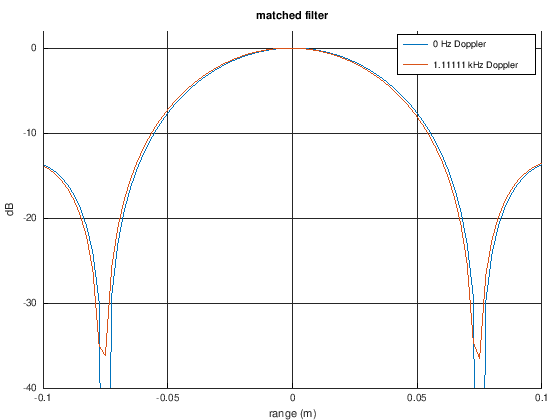

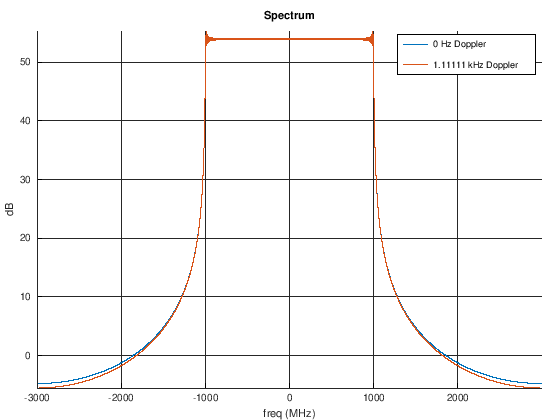

In [1]:
addpath ./tools/matlab/
vdop_kph = 100;
% vdop = 5;
vdop = vdop_kph*1e3/(60*60);

fc = 6e9;
fdop = 2*vdop*(fc/3.0e8);

fs = 6e9;
N = 2048*40;
n = [0:(N-1)]-N/2;
bw = 2000e6;
t = n./fs;

s = exp(1i*pi*.5*(bw/t(end))*t.^2);

% figure; plot(real(s));

t1 = t - t(1);
r = s.*exp(1i*2*pi*fdop*t1);

freq = n*(fs/N);
figure; hold on;
plot(freq/1e6,20*log10(abs(fftshift(fft(s))))); 
plot(freq/1e6,20*log10(abs(fftshift(fft(r))))); 
grid on; axis tight;xlabel('freq (MHz)'); ylabel('dB');title('Spectrum');
legend('0 Hz Doppler',sprintf('%g kHz Doppler',fdop/1e3));

upfac = 10;
fs_u = fs*upfac;

[d0,l0] = mfiltu(s,s,upfac);
[d1,l1] = mfiltu(r,s,upfac);

d0 = d0./numel(d0);
d1 = d1./numel(d1);

rng0 = 3e8*.5*(l0/(fs_u));
rng1 = 3e8*.5*(l1/(fs_u));

figure; hold on; 
plot(rng0,20*log10(abs(d0)));
plot(rng1,20*log10(abs(d1)));
axis([-.1,.1,-40,2]);
grid on; xlabel('range (m)'); ylabel('dB'); title('matched filter');
legend('0 Hz Doppler',sprintf('%g kHz Doppler',fdop/1e3));

% [~,imax] = max(abs(d0));
% r_max0 = rng0(imax)
% [~,imax] = max(abs(d1));
% r_max1 = rng1(imax)

pk0 = peak_poly_estimate(l0,20*log10(abs(d0)),2);            
pk1 = peak_poly_estimate(l1,20*log10(abs(d1)),2);            

r_pk0 = 3e8*.5*pk0/fs_u;
r_pk1 = 3e8*.5*pk1/fs_u;
fprintf('doppler: %g kHz (%g m/s). range shift: %g cm\n',fdop/1e3,vdop,r_pk1*1e2)

%%
% fc = 6e9;
% fdop = 1000
% vdop = 3e8*fdop/(2*fc)
% vdop_kph = vdop*(60*60)/(1e3)

## Ambiguity Function
\begin{align}
\chi (\tau,f) &=\int s(t)s^{*}(t-\tau)e^{j2\pi f t}dt
\end{align}

### LFM Chirp

\begin{align}
s(t) &= \frac{1}{\sqrt{T}} rect \Big (\frac{t}{T} \Big) e^{j \pi k t^2}
\end{align}

where $k=B/T$, $B$ is the bandwidth and $T$ is the pulse length.

Now the ambiguity function is 
\begin{align}
\chi (\tau,f) &= \frac{1}{T}\int_{-\infty}^{\infty} rect \Big (\frac{t}{T} \Big) rect \Big (\frac{t-\tau}{T} \Big) e^{j \pi k t^2} e^{-j \pi k (t-\tau)^2} e^{j2\pi f t} dt
\end{align}

For $T \geq \tau \geq 0$:
\begin{align}
\chi (\tau,f) &= \frac{1}{T}\int_{-T/2 + \tau}^{T/2} rect \Big (\frac{t}{T} \Big) rect \Big (\frac{t-\tau}{T} \Big) e^{j \pi k t^2} e^{-j \pi k (t-\tau)^2} e^{j2\pi f t} dt \\
&= \frac{1}{T}e^{j\pi f \tau}(T-\tau) sinc \big( (k \tau + f)(T - \tau) \big)
\end{align}

For $-T \leq \tau \leq 0$:
\begin{align}
\chi (\tau,f) &= \frac{1}{T}\int_{-T/2}^{T/2+\tau} rect \Big (\frac{t}{T} \Big) rect \Big (\frac{t-\tau}{T} \Big) e^{j \pi k t^2} e^{-j \pi k (t-\tau)^2} e^{j2\pi f t} dt \\
&= \frac{1}{T}e^{j\pi f \tau}(T+\tau) sinc \big( (k \tau + f)(T + \tau) \big)
\end{align}

Thus the LFM chirp ambiguity function is
\begin{align}
\chi (\tau,f) &= \frac{1}{T}e^{j\pi f \tau}(T - |\tau|) sinc \big( (k \tau + f)(T - |\tau|) \big) \qquad |\tau|\leq T
\end{align}
where $sinc (x) = \frac{sin(\pi x)}{\pi x}$


fs: 5000 MHz. BW: 2500 MHz. T_p: 20.48 us. TxBW: 51200. Max Doppler: 10 kHz. Max shift: 1.22874 cm


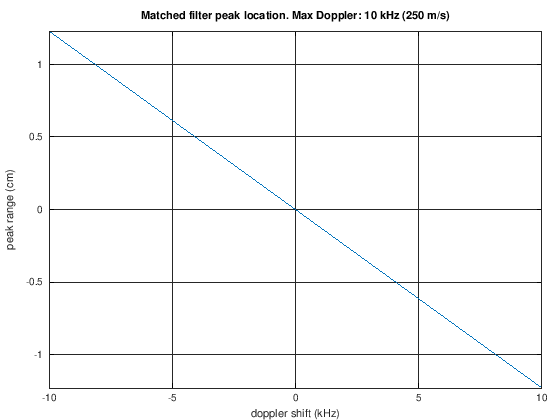

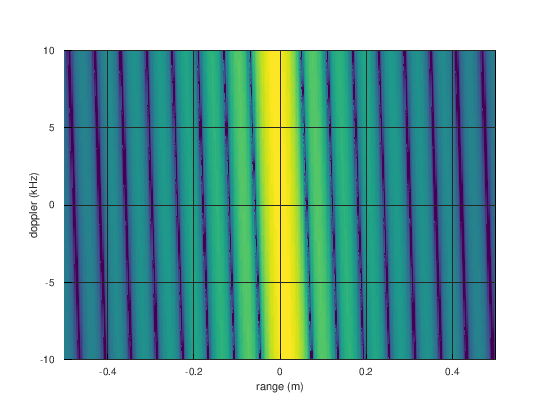

In [2]:
fdop = -1e4:1e2:1e4; % doppler shifts for ambiguity function
fc = 6e9; % center frequency

fs = 5000e6; % sampling rate
bw = 2500e6; % total bandwidth

subpulse_bw = 50e6; % sub-pulse bandwidth (for determining num subpulses)
N_subpulse = ceil(bw/subpulse_bw); % for determining accurate length N

N = 2048*N_subpulse;
n = [0:(N-1)]-N/2;
t = n./fs;

vdop = 3e8*fdop/(2*fc);

% reference chirp
s = exp(1i*pi*.5*(bw/t(end))*t.^2);

t1 = t - t(1);

upfac = 10;
fs_u = fs*upfac;

rmin = -.5; 
rmax = .5;
D = [];
R_pk = zeros(1,numel(fdop));
for i=1:numel(fdop)
    r = s.*exp(1i*2*pi*fdop(i)*t1);
    [d1,l1] = mfiltu(r,s,upfac);
    rng1 = 3e8*.5*(l1/(fs_u));
    pk1 = peak_poly_estimate(l1,20*log10(abs(d1)),2);            
    R_pk(i) = 3e8*.5*pk1/fs_u;
    
    [~,imin]=min(abs(rng1-rmin));
    [~,imax]=min(abs(rng1-rmax));
    D = [D;d1(imin:imax)./numel(d1)];
end

rng1 = 3e8*.5*(l1(imin:imax)/(fs_u));

[R,F] = meshgrid(rng1,fdop);

D_db = 20*log10(abs(D));
D_db(D_db<-50)=-50;
figure; surf(R,F./1e3,D_db,'EdgeColor','none');
xlabel('range (m)'); ylabel('doppler (kHz)'); zlabel('dB');
view([0,90]); axis tight

figure; plot(fdop/1e3,R_pk*1e2); 
grid on; axis tight; 
title(sprintf('Matched filter peak location. Max Doppler: %g kHz (%g m/s)',fdop(end)/1e3,vdop(end)));
xlabel('doppler shift (kHz)'); ylabel('peak range (cm)');

T_p = N/fs;
TxBW = T_p * bw;

fprintf('fs: %g MHz. BW: %g MHz. T_p: %g us. TxBW: %g. Max Doppler: %g kHz. Max shift: %g cm\n',fs/1e6,bw/1e6,T_p*1e6,TxBW,max(fdop)/1e3,max(R_pk)*1e2);

